In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import jax.numpy as jnp
import jax
import jax.nn as nn
import equinox as eqx
import jax_dataloader as jdl

from tqdm import tqdm
import typing as tp
import pandas as pd
import math
from dataclasses import asdict

import sys

import optax
import numpyro.distributions as D

from diffcv.dist.gaussian_mixture import GaussianMixture
from diffcv.mcmc.base import Sampler
from diffcv.mcmc.langevin import ULASampler, MALASampler
from diffcv.mcmc.pyro import HMCSampler
from diffcv.cv.nn import (
    CVMLP,
    ModelWithConstant,
    init_linear,
    he_uniform_init,
    xavier_uniform_init,
    zero_init,
)
from diffcv.cv.training import CVTrainer, CVALSTrainer
from diffcv.cv.loss import DiffusionLoss, DiffLoss, VarLoss
from diffcv.logger import Logger, plot_log_results
from diffcv.cv.data import get_data_from_sampler
from diffcv.cv.utils import recu, requ
from diffcv.cv.generator import ScalarGenerator
from diffcv.mcmc.estimator import Estimator
from diffcv.config import *

sns.set_style("darkgrid")

In [3]:
sampler_config = SamplerConfig(
    dim=10,
    gamma=8e-2,
    init_std=5.0,
)

sampling_config = SamplingConfig(
    steps=1_000,
    burnin_steps=1_000,
    skip_steps=2,
)

estimator_config = EstimatorConfig(
    sampling_config=sampling_config,
    total_samples=20_000,
    n_estimates=1_000,
)

model_config = ModelConfig(
    depth=2,
    width_size=64,
    activation=requ,
)

scheduler_config = SchedulerConfig(
    init_value=1e-4,
    transition_steps=20_000,
    decay_rate=0.9,
)

optimizer_config = OptimizerConfig(
    method="adamw",
    weight_decay=1e-2,
)

trainer_config = TrainerConfig(
    batch_size=256,
    train_size=5_000,
    eval_size=20_000,
    grad_clipping=10,
    patience=3_000,
    eval_every_n_steps=2_000,
    n_steps=30_000,
    scheduler_config=scheduler_config,
    optimizer_config=optimizer_config,
    sampling_config=sampling_config,
)

2024-08-22 22:52:05.009990: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


true pi(f) =  1010.000


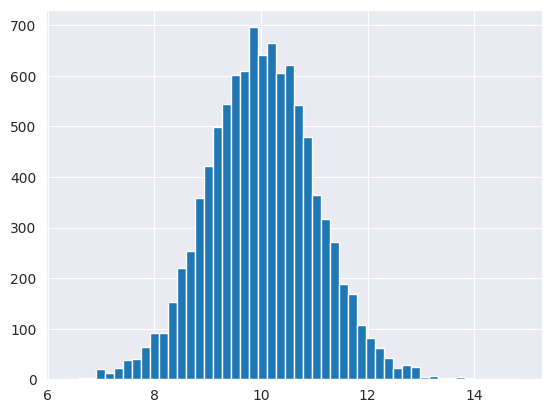

In [4]:
rng = jax.random.PRNGKey(50)

dist = D.MultivariateNormal(
    loc=10 * jnp.ones((sampler_config.dim), dtype=float),
    covariance_matrix=jnp.eye((sampler_config.dim), dtype=float),
)
log_prob = jax.jit(dist.log_prob)
grad_log_prob = jax.jit(jax.grad(dist.log_prob))

fn = jax.jit(lambda x: (x**2).sum(axis=-1))
true_pi = (dist.mean**2).sum() + dist.variance.sum()

print(f"true pi(f) = {true_pi: .3f}")

sampler = MALASampler(log_prob=log_prob, **asdict(sampler_config))
rng, key = jax.random.split(rng)
samples = sampler(key, **asdict(estimator_config.sampling_config), n_chains=10).reshape(
    -1, sampler_config.dim
)

plt.hist(samples[:, 0], bins=50)
plt.show()

In [12]:
def get_model(key: jax.random.PRNGKey, in_size: int, model_config: ModelConfig):
    key1, key2 = jax.random.split(key, 2)
    model = CVMLP(in_size=in_size, **asdict(model_config), key=key1)
    model = init_linear(model, key2, he_uniform_init, zero_init)
    return model


def get_scheduler(scheduler_config: SchedulerConfig):
    return optax.exponential_decay(**asdict(scheduler_config))


def get_optimizer(scheduler: optax.Schedule, optimizer_config: OptimizerConfig):
    if optimizer_config.method == "sgd":
        return optax.inject_hyperparams(optax.sgd)(learning_rate=scheduler)
    elif optimizer_config.method == "adam":
        return optax.inject_hyperparams(optax.adam)(learning_rate=scheduler)
    elif optimizer_config.method == "adamw":
        weight_mask = lambda m: jax.tree_util.tree_map(lambda x: x.ndim > 1, m)
        return optax.inject_hyperparams(optax.adamw)(
            learning_rate=scheduler,
            weight_decay=optimizer_config.weight_decay,
            mask=weight_mask,
        )
    else:
        raise NotImplementedError(f"unknown optimizer: {optimizer_config.method}")

In [6]:
rng, key = jax.random.split(rng)
base_estimates = Estimator(fn, sampler)(key, estimator_config)
print("base:", Estimator.bias(true_pi, base_estimates), Estimator.std(base_estimates))

  0%|          | 0/1000 [00:00<?, ?it/s]

base: -0.0017700195 1.5573097


train_dataset length: 5000
eval_dataset length: 20000


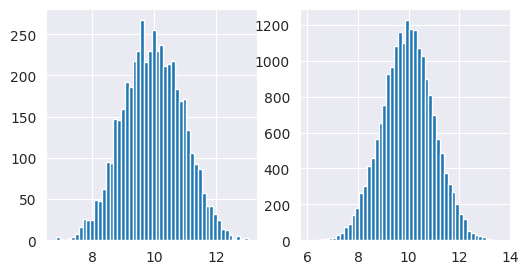

In [7]:
train_dataloader = get_data_from_sampler(
    key,
    trainer_config.batch_size,
    sampler,
    total_samples=trainer_config.train_size,
    sampling_config=trainer_config.sampling_config,
)
print(f"train_dataset length: {len(train_dataloader.dataloader.dataset)}")

eval_dataloader = get_data_from_sampler(
    key,
    trainer_config.batch_size,
    sampler,
    total_samples=trainer_config.eval_size,
    sampling_config=trainer_config.sampling_config,
)
print(f"eval_dataset length: {len(eval_dataloader.dataloader.dataset)}")

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.hist(train_dataloader.dataloader.dataset[:, 0], bins=50)
plt.subplot(1, 2, 2)
plt.hist(eval_dataloader.dataloader.dataset[:, 0], bins=50)
plt.show()

  0%|          | 0/30000 [00:00<?, ?it/s]

Early stopping at step 3512 due to no improvement in loss over 3000 steps.


  0%|          | 0/1000 [00:00<?, ?it/s]

diffusion: 0.039489746 0.84067607


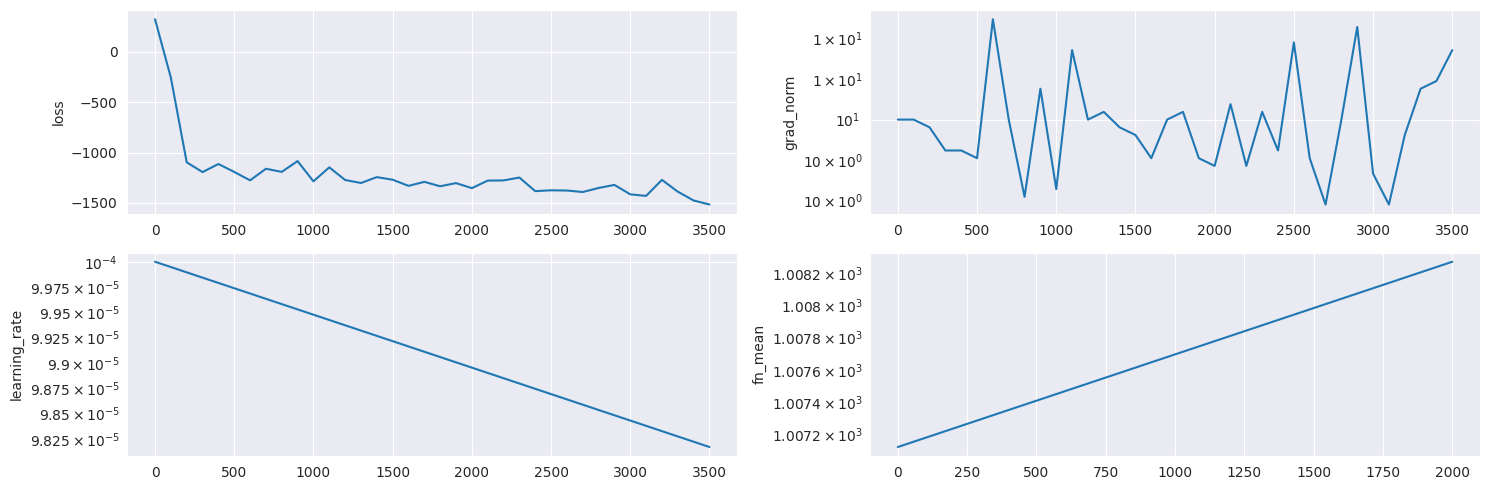

In [8]:
logger = Logger()

rng, key = jax.random.split(rng)
model_diffusion = get_model(key, sampler_config.dim, model_config)
loss = DiffusionLoss(fn=fn)

optimizer = get_optimizer(
    get_scheduler(trainer_config.scheduler_config), trainer_config.optimizer_config
)

rng, key = jax.random.split(rng)
trainer = CVTrainer(
    model_diffusion,
    fn,
    grad_log_prob,
    train_dataloader,
    eval_dataloader,
    optimizer,
    loss,
    logger,
    fn_mean=base_estimates.mean(),
    **asdict(trainer_config),
)
model = trainer.train(key)

plot_log_results(logger)

generator_diffusion = ScalarGenerator(grad_log_prob, model_diffusion)
fn_with_cv = lambda x: fn(x) + generator_diffusion(x)

rng, key = jax.random.split(rng)
diffusion_estimates = Estimator(fn_with_cv, sampler)(key, estimator_config)

print(
    "diffusion:",
    Estimator.bias(true_pi, diffusion_estimates),
    Estimator.std(diffusion_estimates),
)

In [11]:
for layer in model_diffusion.mlp.layers:
    print("w", (layer.weight**2).sum(), layer.weight.shape)
    print("b", (layer.bias**2).sum(), layer.bias.shape)

w 20.86436 (64, 10)
b 0.36206347 (64,)
w 21.742352 (64, 64)
b 1.4692523 (64,)
w 0.41575012 (1, 64)
b 0.050794285 (1,)


  0%|          | 0/30000 [00:00<?, ?it/s]

train fn_mean:  1009.841
train fn_mean:  1009.748
train fn_mean:  1009.866
train fn_mean:  1009.815
train fn_mean:  1009.838
Early stopping at step 9001 due to no improvement in diffusion loss over 3000 steps.


  0%|          | 0/1000 [00:00<?, ?it/s]

diffusion als: 0.1430664 2.4587774


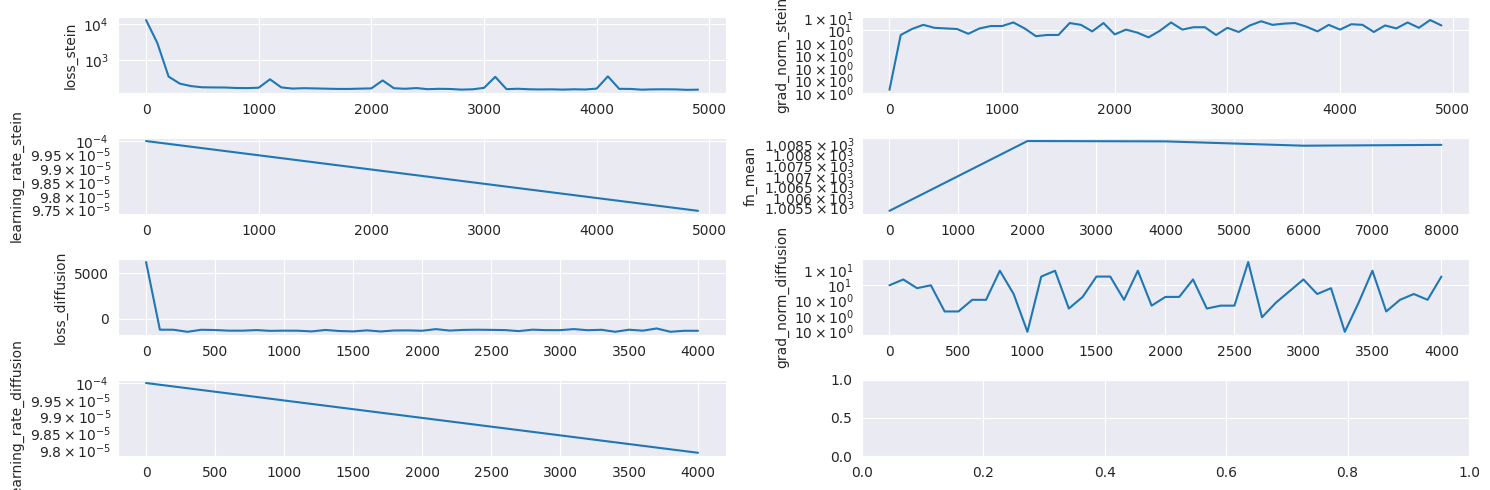

In [13]:
logger = Logger()

rng, key = jax.random.split(rng)
model_diffusion_als = get_model(key, sampler_config.dim, model_config)

scheduler_diffusion = get_scheduler(trainer_config.scheduler_config)
optimizer_diffusion = get_optimizer(
    scheduler_diffusion, trainer_config.optimizer_config
)

scheduler_stein = get_scheduler(trainer_config.scheduler_config)
optimizer_stein = get_optimizer(scheduler_stein, trainer_config.optimizer_config)

loss_diffusion = DiffusionLoss(fn=fn)
loss_stein = DiffLoss(fn=fn, grad_log_prob=grad_log_prob, noise_std=1.0)

rng, key = jax.random.split(rng)
trainer = CVALSTrainer(
    model_diffusion_als,
    fn,
    grad_log_prob,
    train_dataloader,
    eval_dataloader,
    optimizer_diffusion,
    optimizer_stein,
    loss_diffusion,
    loss_stein,
    logger=logger,
    **asdict(trainer_config),
    switch_steps=5000,
)

model = trainer.train(key)

plot_log_results(logger)

generator_diffusion_als = ScalarGenerator(grad_log_prob, model_diffusion_als)
fn_with_cv = lambda x: fn(x) + generator_diffusion_als(x)

rng, key = jax.random.split(rng)
diffusion_als_estimates = Estimator(fn_with_cv, sampler)(key, estimator_config)

print(
    "diffusion als:",
    Estimator.bias(true_pi, diffusion_als_estimates),
    Estimator.std(diffusion_als_estimates),
)

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

diff: -0.16619873 3.0773935


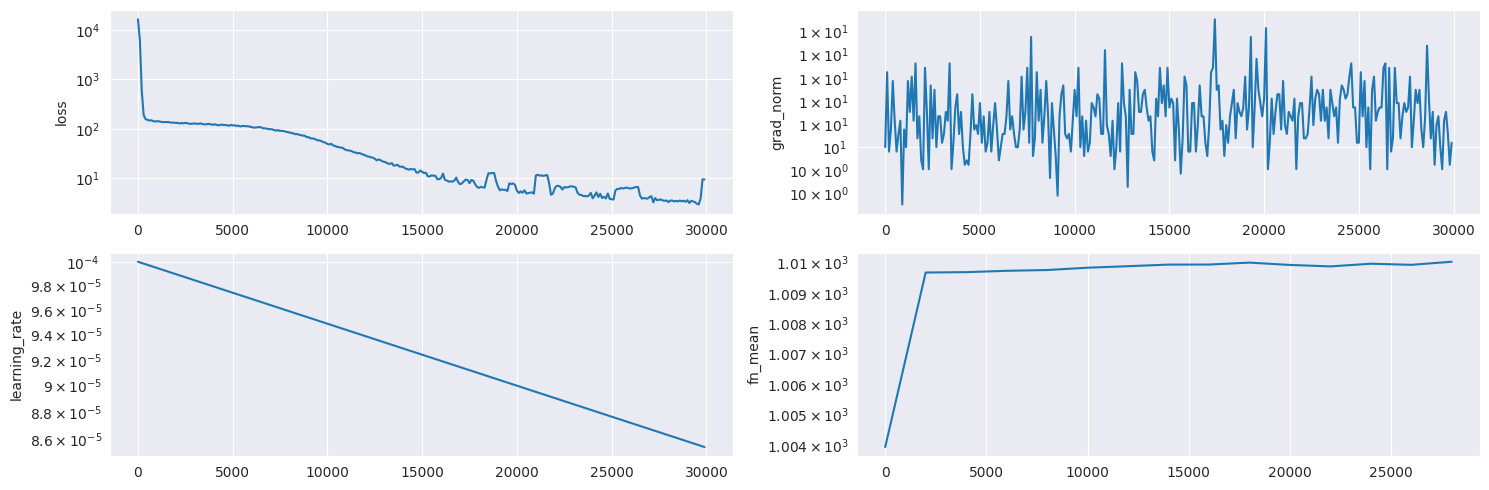

In [14]:
logger = Logger()

rng, key = jax.random.split(rng)
model_diff = get_model(key, sampler_config.dim, model_config)
loss = DiffLoss(fn=fn, grad_log_prob=grad_log_prob, noise_std=1.0)

optimizer = get_optimizer(
    get_scheduler(trainer_config.scheduler_config), trainer_config.optimizer_config
)

rng, key = jax.random.split(rng)
trainer = CVTrainer(
    model_diff,
    fn,
    grad_log_prob,
    train_dataloader,
    eval_dataloader,
    optimizer,
    loss,
    logger,
    fn_mean=None,
    **asdict(trainer_config),
)
model_diff = trainer.train(key)

plot_log_results(logger)

generator_diff = ScalarGenerator(grad_log_prob, model_diff)
fn_with_cv = lambda x: fn(x) + generator_diff(x)

rng, key = jax.random.split(rng)
diff_estimates = Estimator(fn_with_cv, sampler)(key, estimator_config)

print(
    "diff:",
    Estimator.bias(true_pi, diff_estimates),
    Estimator.std(diff_estimates),
)

In [17]:
rhs = lambda x: (x**2).sum() - true_pi
rhs_samples = jax.vmap(rhs)(samples)
generator_diffusion_samples = jax.vmap(generator_diffusion)(samples)
generator_diffusion_als_samples = jax.vmap(generator_diffusion_als)(samples)
generator_diff_samples = jax.vmap(generator_diff)(samples)

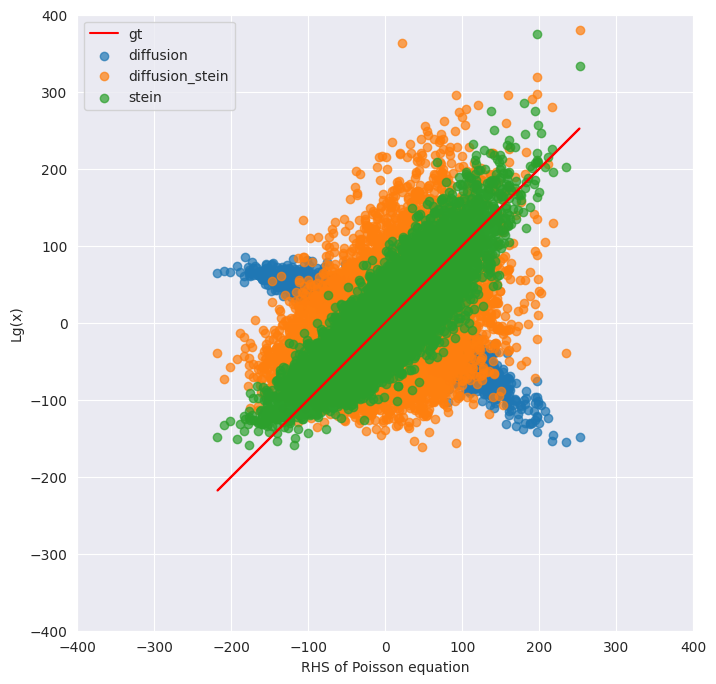

In [18]:
plt.figure(figsize=(8, 8))
plt.plot(rhs_samples, rhs_samples, color="red")
plt.scatter(rhs_samples, generator_diffusion_samples, alpha=0.7)
plt.scatter(rhs_samples, generator_diffusion_als_samples, alpha=0.7)
plt.scatter(rhs_samples, generator_diff_samples, alpha=0.7)
plt.legend(["gt", "diffusion", "diffusion_stein", "stein"])
plt.axis("scaled")
minx = (
    min(
        generator_diff_samples.min(),
        generator_diffusion_samples.min(),
        generator_diffusion_als_samples.min(),
    )
    .astype(int)
    .item()
)
maxx = (
    max(
        generator_diff_samples.max(),
        generator_diffusion_samples.max(),
        generator_diffusion_als_samples.max(),
    )
    .astype(int)
    .item()
)
plt.ylim((-400, 400))
plt.xlim((-400, 400))
plt.xlabel("RHS of Poisson equation")
plt.ylabel("Lg(x)")
plt.show()

In [ ]:
# x = jnp.linspace(-6., 6., 100)
# plt.plot(x, jax.vmap(model_diffusion)(x.reshape(-1, DIST_DIM)))
# plt.plot(x, jax.vmap(model_diffusion_als)(x.reshape(-1, DIST_DIM)))
# plt.plot(x, jax.vmap(model_diff)(x.reshape(-1, DIST_DIM)))
# plt.legend(["diffusion", "diffusion_stein", "stein"])

(50000,)

In [ ]:
# x = jnp.linspace(-6., 6., 100)
# rhs = lambda x: x ** 2 - 1 - a ** 2
# plt.plot(x, rhs(x.reshape(-1, DIST_DIM)))
# plt.plot(x, -jax.vmap(generator_diffusion)(x.reshape(-1, DIST_DIM)))
# plt.plot(x, -jax.vmap(generator_diffusion_als)(x.reshape(-1, DIST_DIM)))
# plt.plot(x, -jax.vmap(generator_diff)(x.reshape(-1, DIST_DIM)))
# plt.legend(["rhs", "diffusion", "diffusion_als", "stein"])

  0%|          | 0/30000 [00:00<?, ?it/s]

Early stopping at step 7130 due to no improvement in loss over 3000 steps.
learned constant: [0.7343901]


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

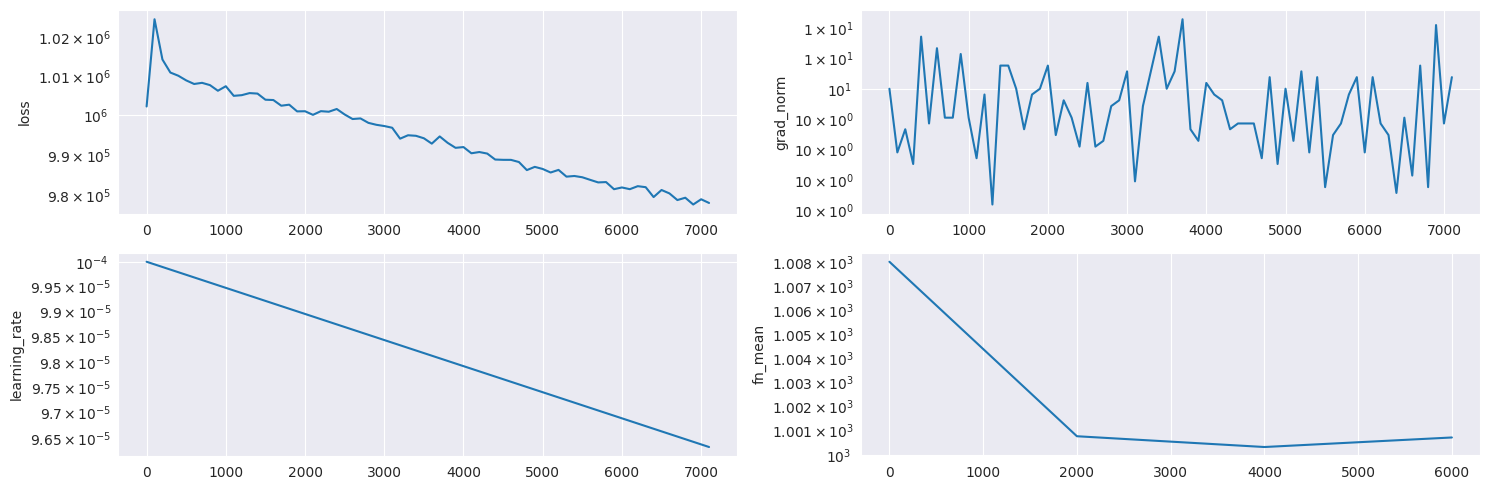

In [20]:
logger = Logger()

rng, key = jax.random.split(rng)
model_var = get_model(key, sampler_config.dim, model_config)
rng, key = jax.random.split(rng)
model_var = ModelWithConstant(model_var, (1,), key)
loss = VarLoss(fn=fn, grad_log_prob=grad_log_prob)

optimizer = get_optimizer(
    get_scheduler(trainer_config.scheduler_config), trainer_config.optimizer_config
)

rng, key = jax.random.split(rng)
trainer = CVTrainer(
    model_var,
    fn,
    grad_log_prob,
    train_dataloader,
    eval_dataloader,
    optimizer,
    loss,
    logger,
    fn_mean=None,
    **asdict(trainer_config),
)
model_var = trainer.train(key)

plot_log_results(logger)

print(f"learned constant: {model_var.c}")
model_var = model_var.model

generator_var = ScalarGenerator(grad_log_prob, model_diff)
fn_with_cv = lambda x: fn(x) + generator_var(x)

rng, key = jax.random.split(rng)
var_estimates = Estimator(fn_with_cv, sampler)(key, estimator_config)

print(
    "var:",
    Estimator.bias(true_pi, var_estimates),
    Estimator.std(var_estimates),
)

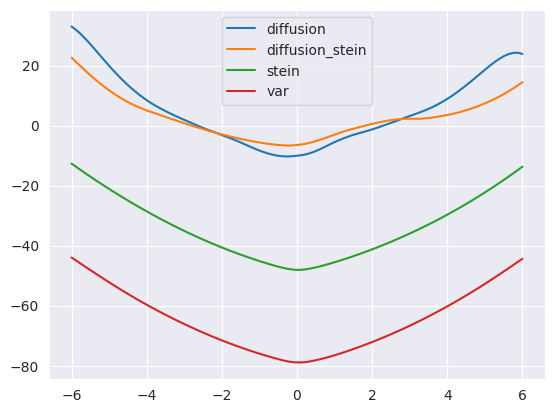

In [ ]:
x = jnp.linspace(-6.0, 6.0, 100)
plt.plot(x, jax.vmap(model_diffusion)(x.reshape(-1, DIST_DIM)))
plt.plot(x, jax.vmap(model_diffusion_als)(x.reshape(-1, DIST_DIM)))
plt.plot(x, jax.vmap(model_diff)(x.reshape(-1, DIST_DIM)))
plt.plot(x, jax.vmap(model_var)(x.reshape(-1, DIST_DIM)))
plt.legend(["diffusion", "diffusion_stein", "stein", "var"])

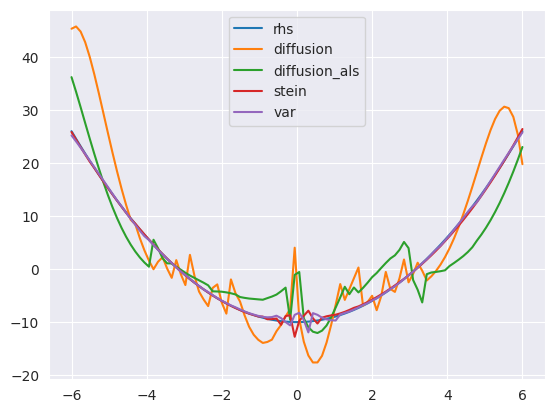

In [ ]:
x = jnp.linspace(-6.0, 6.0, 100)
rhs = lambda x: x**2 - 1 - a**2
plt.plot(x, rhs(x.reshape(-1, DIST_DIM)))
plt.plot(x, -jax.vmap(generator_diffusion)(x.reshape(-1, DIST_DIM)))
plt.plot(x, -jax.vmap(generator_diffusion_als)(x.reshape(-1, DIST_DIM)))
plt.plot(x, -jax.vmap(generator_diff)(x.reshape(-1, DIST_DIM)))
plt.plot(x, -jax.vmap(generator_var)(x.reshape(-1, DIST_DIM)))
plt.legend(["rhs", "diffusion", "diffusion_als", "stein", "var"])

In [ ]:
def diff_run(dist_dim: int):
    rng = jax.random.PRNGKey(50)

    dist = D.MultivariateNormal(
        loc=10 * jnp.ones((dist_dim), dtype=float),
        covariance_matrix=jnp.eye((dist_dim), dtype=float),
    )
    log_prob = jax.jit(dist.log_prob)
    grad_log_prob = jax.jit(jax.grad(dist.log_prob))

    fn = jax.jit(lambda x: (x**2).sum(axis=-1))
    true_pi = (dist.mean**2).sum() + dist.variance.sum()

    sampler = MALASampler(
        log_prob=log_prob,
        dim=dist_dim,
        n_samples=SAMPLER_N_SAMPLES,
        gamma=5e-2,
        burnin_steps=SAMPLER_N_BURNIN,
        init_std=3.0,
    )

    train_size = 900 + 10 * dist_dim
    eval_size = 20_000

    rng, key = jax.random.split(rng)
    train_dataloader = get_data_from_sampler(
        BATCH_SIZE, sampler, key, n_chains=train_size // SAMPLER_N_SAMPLES
    )
    print(f"train_dataset length: {len(train_dataloader.dataloader.dataset)}")

    rng, key = jax.random.split(rng)
    eval_dataloader = get_data_from_sampler(
        BATCH_SIZE, sampler, key, n_chains=eval_size // SAMPLER_N_SAMPLES
    )
    print(f"eval_dataset length: {len(eval_dataloader.dataloader.dataset)}")

    logger = Logger()

    rng, key = jax.random.split(rng)
    model = train_model(
        key=key,
        dist_dim=dist_dim,
        fn=fn,
        grad_log_prob=grad_log_prob,
        train_dataloader=train_dataloader,
        eval_dataloader=eval_dataloader,
        lr=1e-3,
        loss_fn="diff",
        optim="adam",
        n_steps=40_000 + 100 * dist_dim,
        fn_mean=None,
        patience=20_000,
        logger=logger,
    )

    plot_log_results(logger)

    generator = ScalarGenerator(grad_log_prob, model)
    fn_with_cv = lambda x: fn(x) + generator(x)

    rng, key = jax.random.split(rng)
    estimates = Estimator(fn_with_cv, sampler)(key, n_chains=10, n_estimates=100)

    bias, std = Estimator.bias(true_pi, estimates), Estimator.std(estimates)
    print(dist_dim, bias, std)
    return bias, std

In [ ]:
from collections import defaultdict

In [ ]:
results = defaultdict(list)

train_dataset length: 10000
eval_dataset length: 20000


  0%|          | 0/140000 [00:00<?, ?it/s]

Early stopping at step 67221 due to no improvement in loss over 20000 steps.


  0%|          | 0/100 [00:00<?, ?it/s]

1000 5.25 43.34301


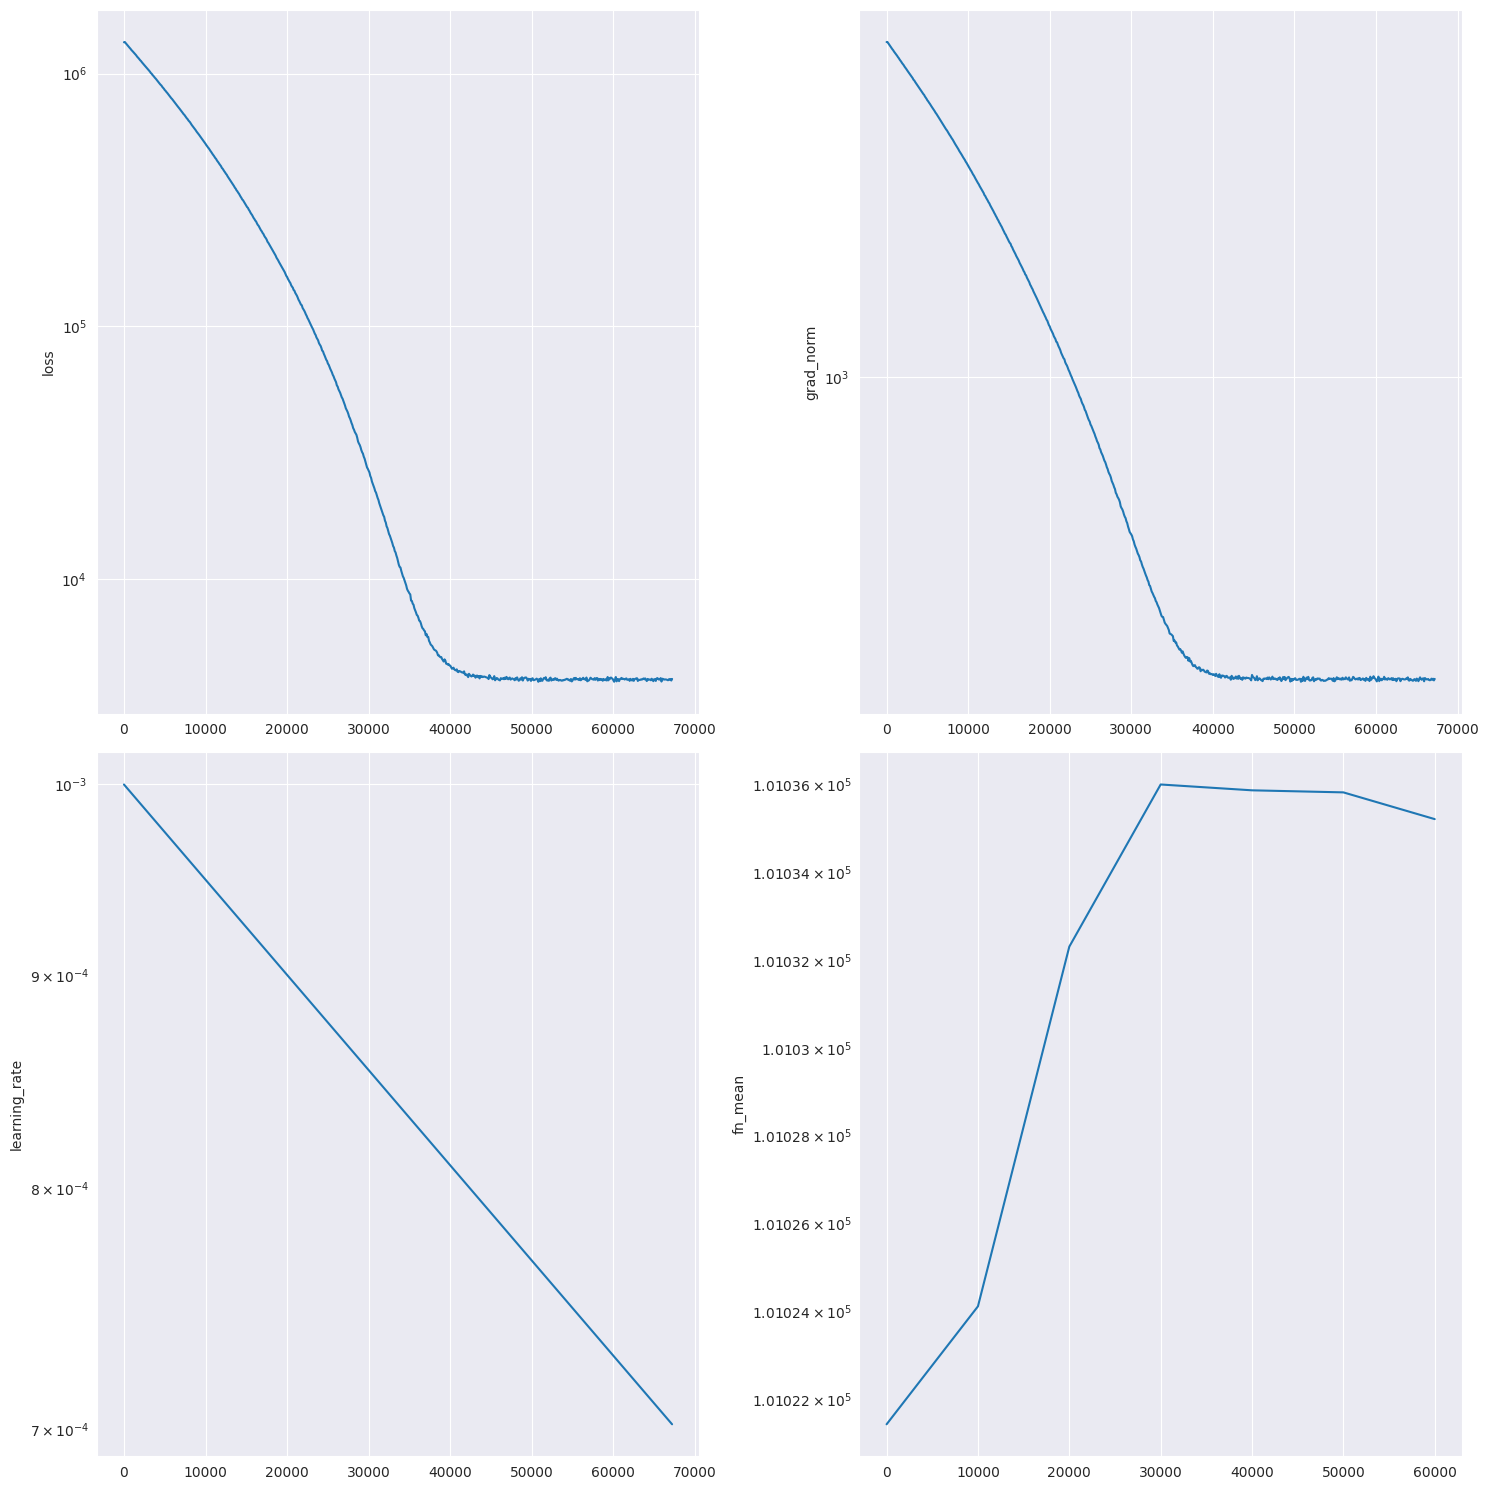

In [ ]:
for dist_dim in [1000]:
    bias, std = diff_run(dist_dim)
    results["diff"] = {"bias": bias, "std": std, "dim": dist_dim}

In [ ]:
t1000 = results["diff"]

In [ ]:
results["diff"]

[{'bias': Array(5.25, dtype=float32),
  'std': Array(43.34301, dtype=float32),
  'dim': 1000},
 {'bias': -6.1035156e-05, 'std': 0.08799228, 'dim': 10},
 {'bias': 0.025390625, 'std': 1.442239, 'dim': 100}]

In [ ]:
a = 3
dist = D.Mixture(
    mixing_distribution=D.Categorical(jnp.asarray([0.5, 0.5])),
    component_distributions=[D.Normal(loc=-a, scale=1), D.Normal(loc=a, scale=1)],
)

2024-08-14 15:00:11.737491: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [ ]:
grad_log_prob = jax.grad(dist.log_prob)

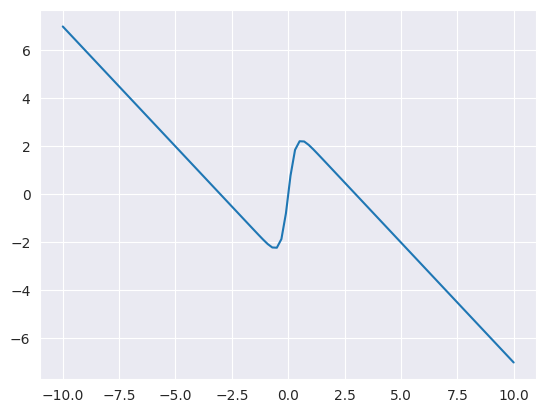

In [ ]:
x = np.linspace(-10, 10, 100)
y = jax.vmap(grad_log_prob)(x)
plt.plot(x, y)

$$
p_1(x) = \mathcal{N}(-a, 1), p_2(x) = \mathcal{N}(a, 1)
\\
p(x) = 0.5 p_1(x) + 0.5 p_2(x)
\\
\\
(\log p(x))' y'(x) + y''(x) = x^2 - 1 - a^2
\\
y'(x) = u(x)
\\
u(x) = \frac{C(x)}{p(x)}
\\
C(x) = \int_{-\infty}^{x} (t^2 - 1 - a^2) p(t) dt
\\
y(x) = \int_{-\infty}^{x} \frac{C(t)}{p(t)} dt + C
$$

In [ ]:
from scipy.integrate import quad

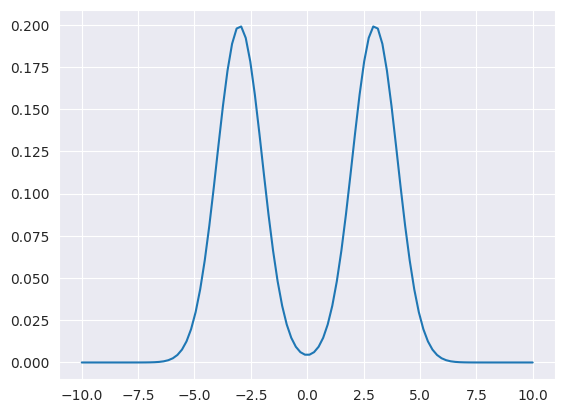

In [ ]:
def get_normal_density(loc, scale=1):
    def density(x):
        return (
            1
            / (np.sqrt(2 * np.pi) * scale)
            * np.exp(-0.5 / (scale * scale) * ((x - loc) ** 2))
        )

    return density


def get_mixture_density(coeffs, locs, scales):
    ps = [get_normal_density(loc, scale) for loc, scale in zip(locs, scales)]

    def density(x):
        ans = 0.0
        for c, p in zip(coeffs, ps):
            ans += c * p(x)
        return ans

    return density


p_mixture = get_mixture_density([0.5, 0.5], [-3, 3], [1, 1])
plt.plot(x, p_mixture(x))

In [ ]:
def C(x):
    return (x**2 - 1 - a**2) * p_mixture(x)


def get_u(C_int):
    def u(x):
        return C_int


ts = np.linspace(-1000, 1000, 1000)
C_int = [quad(C, -np.inf, t)[0] for t in ts]